# The Hello World program of Quantum Computing
This is the classical CHSH experiment. In a classical world the operator could not give a value outside -2 -> +2. A demonstration of a measured value above +2 or below -2 is only possible due to entanglement  

## **Step 0**: Setup

In [29]:
import numpy as np

# Qiskit Quantum Circuit
from qiskit import QuantumCircuit

# Qiskit Operator form
from qiskit.quantum_info import SparsePauliOp

# Import Qiskit packages
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum", instance="executive/internal/main")

# Define backend
use_real = True

if use_real:
    backend = service.backend('ibmq_kolkata')
else:
    backend = service.backend('ibmq_qasm_simulator')

## **Step 1**: Problem specification using standard tools and conversion to Quantum native format
Here we define the CHSH operator to be measured (ZZ+XX+XZ-ZX) and the phases to be used in the quantum circuit. The output of this step should be an operator to be measured and a quantum circuit

In [26]:
number_of_phases = 20
phases = np.linspace(0, 2*np.pi, number_of_phases)
chsh = SparsePauliOp.from_list([('ZZ', 1), ('ZX', -1), ('XZ', 1), ('XX', 1)])
print(chsh)

SparsePauliOp(['ZZ', 'ZX', 'XZ', 'XX'],
              coeffs=[ 1.+0.j, -1.+0.j,  1.+0.j,  1.+0.j])


In [27]:
from qiskit.circuit import Parameter

th = Parameter('th')
chsh_circuit = QuantumCircuit(2)
chsh_circuit.h(0)
chsh_circuit.cx(0, 1)
chsh_circuit.ry(th, 0)

print(chsh_circuit)

     ┌───┐     ┌────────┐
q_0: ┤ H ├──■──┤ Ry(th) ├
     └───┘┌─┴─┐└────────┘
q_1: ─────┤ X ├──────────
          └───┘          


## **Step 2**: Optimize the circuits and the operators to be measured

The Native set for the IBM Hardware is control-z, sqrt-x and a rotation around the z-axis [cz, sx, rz]. 

In [30]:
from qiskit.compiler import transpile
chsh_ibm = transpile(chsh_circuit, basis_gates = ['cz', 'sx', 'rz'], optimization_level=3)
print(chsh_ibm)

     ┌─────────┐┌────┐┌─────────┐   ┌────┐┌────────────┐┌────┐┌────────┐
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(π/2) ├─■─┤ √X ├┤ Rz(th + π) ├┤ √X ├┤ Rz(3π) ├
     ├─────────┤├────┤└┬───────┬┘ │ ├────┤└┬─────────┬─┘└────┘└────────┘
q_1: ┤ Rz(π/2) ├┤ √X ├─┤ Rz(π) ├──■─┤ √X ├─┤ Rz(π/2) ├──────────────────
     └─────────┘└────┘ └───────┘    └────┘ └─────────┘                  


## **Step 3**: Solve using quantum primitive functions
Here we use the estimator primitve and send all the quantum circuits with different phases and measured the same CHSH operator.

In [4]:
options = Options()
options.resilience_level = 1
options.execution.shots = 1000

# Run the experiments

estimator = Estimator(session=backend, options=options)
    
job = estimator.run(circuits=[chsh_circuits]*number_of_phases, 
                    observables=[chsh]*number_of_phases, parameter_values=[[ph] for ph in phases])

from helpers import check_job_status
values = check_job_status(job,'chsh')

chsh.picke


## **Step 4**: Post-process and return answer in classical format
Here we plot the output so the user can view when a measured value is greater than +2 or less than -2

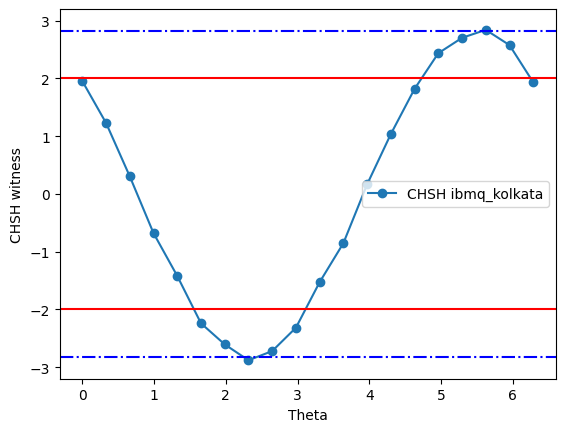

In [5]:
import matplotlib.pyplot as plt

plt.plot(phases, values, 'o-', label='CHSH %s'%(backend.name))

plt.axhline(y=2, color='r', linestyle='-')
plt.axhline(y=-2, color='r', linestyle='-')
plt.axhline(y=np.sqrt(2)*2, color='b', linestyle='-.')
plt.axhline(y=-np.sqrt(2)*2, color='b', linestyle='-.')
plt.ylim(-3.2,3.2)
plt.xlabel('Theta')
plt.ylabel('CHSH witness')
plt.legend(loc="center right")
plt.show()